In [ ]:
# This sample script provides estimates for VI-trajectory based
# load signatures for six key household appliances selected from 
# REDD house_3 high frequency data. Scroll down for visualizations.

# This feature space generally outperforms traditional power metrics
# in non-intrusive load disaggregation and better characterizes 
# operating characteristics of household appliance profiles.

# CITATION INFO
# Taha Hassan et al. (2014), an empirical investigation of VI trajectory based load signatures 
# for non-intrusive load monitoring", Smart Grid, IEEE Transactions on, 5(2), 870-878.

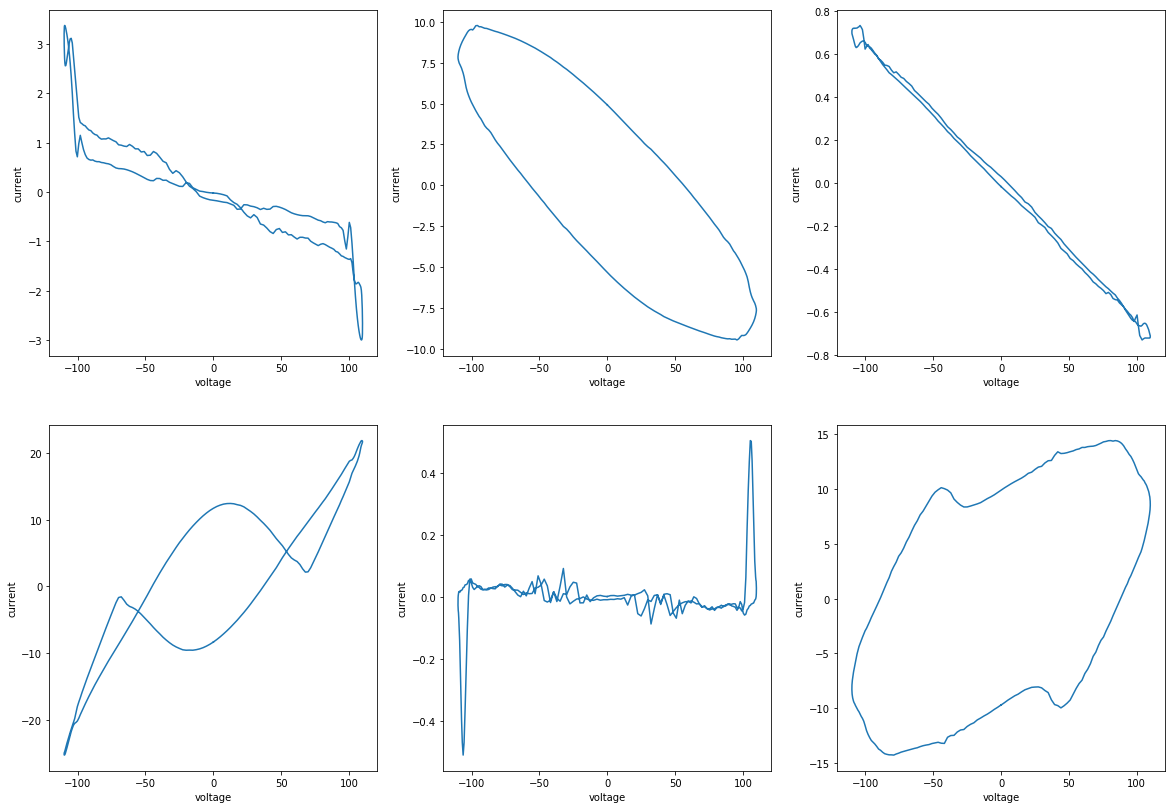

In [3]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
wf = sio.loadmat('wf.mat')['wf3']
si = sio.loadmat('si.mat')['si']

numFeatures = 7
numWaveforms = 6
time = np.arange(0,2.007*np.pi,(2*np.pi/274.0))

vol = 110.*np.sin(time)
fig, ax = plt.subplots(2,3,figsize=(20,14))

for idx in range(numWaveforms):
    plt.subplot(str(231+idx)), plt.plot(vol, wf[idx,:],'-'), plt.xlabel('voltage'), plt.ylabel('current')

In [ ]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.sparse import csr_matrix

wf = sio.loadmat('wf.mat')['wf3']
si = sio.loadmat('si.mat')['si']

numFeatures = 7
numWaveforms = 6
time = np.arange(0,2.007*np.pi,(2*np.pi/274.0))

vol = 110.*np.sin(time)
wfFeatures = np.zeros((numWaveforms, numFeatures))

# ASSERT AREA CONTAINED WITHIN THE VI-LOCUS
def polyarea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

for n in range(0, numWaveforms):
    v, i = vol , wf[n,:]
    viTraj = np.array([v,i]).T
    
    # AREA
    areaEnc = polyarea(v,i)
    
    # CURVATURE OF MIDDLE LINE
    curvML = 0
    c1, c2 = np.argmax(i)+1, np.argmin(i)+1
    if (c1>c2):
        k = c2; c2 = c1; c1 = k
        c2 = c1 + 137
    else:
        c2 = c1 + 137

    if (c2>=276):
        c1 = 138; c2 = 275

    b, a =viTraj[c2-1,:], viTraj[c1-1,:]    
    m=(b[1] - a[1])/(b[0] - a[0])
    
    vh, vh2 = np.concatenate([v[0:c1-1], v[c2-1:275]]), np.concatenate([v[2*c1-2:c1-1:-1], v[c2-1:2*c1 - 3:-1]])
    ih, ih2 = np.concatenate([i[0:c1-1], i[c2-1:275]]), np.concatenate([i[2*c1-2:c1-1:-1], i[c2-1:2*c1 - 3:-1]])
    
    vmk, imk = (vh + vh2) / 2, (ih + ih2) / 2, 
    ist = a[1] + m* (vmk - a[0])
    
    atraj, btraj = np.array([vmk.T, imk.T]).T, np.array([vmk.T, ist.T]).T
    
    curvML = np.sum(np.sqrt(np.sum(pow(btraj-atraj,2),axis=1)))
    
    # SELF-INTERSECTIONS
    temp = si[0,n][0]
    
    q = len(temp)
    numofIntersec = 0
    
    if (areaEnc<0.1) and (curvML<0.1):
        numofIntersec = 0
    else:
        if (q > 0):
            count = len(np.where(temp>0)[0])
            count2 = len(np.where(temp<0)[0])
            if count==count2:
                numofIntersec = 2*count
            else:
                numofIntersec = 2*(count>count2)*count2 + 2*(count2>count)*count
        else:
            numofIntersec = 0
    
    # SLOPE OF MIDDLE SEGMENT
    slMidSeg = 0 
    temp = len(atraj)
    slope = np.zeros((1,temp-1))
    
    for u in range(1, temp):
        t1, t2 = atraj[u-1,:], atraj[u,:]
        slope[0, u-1]= (t2[1] - t1[1] + 0.0) / (t2[0] - t1[0] + 0.0)
        
    slope = (slope+0.0/np.max(abs(slope))).T
    
    if (curvML<0.1) or (areaEnc<0.1):
        slMidSeg = sum(slope)/len(slope)
    else:
        slMidSeg = sum(slope[0:50])/50

    # AREA OF LEFT AND RIGHT SEGMENTS
    if (numofIntersec == 0):
        areaRL = 0
    else:
        areaRL = sum(np.square(slope[50:len(slope)]))
    
    # PEAK OF MIDDLE SEGMENT
    peakMidSeg = 0
    if (numofIntersec == 0):
        peakMidSeg = areaEnc
    
    # DISTANCE BETWEEN HIGHEST AND LOWEST POINT
    distHL = np.linalg.norm(b[1] - a[1])
    wfFeatures[n,:] = [areaEnc, curvML, numofIntersec, slMidSeg, areaRL, peakMidSeg, distHL]


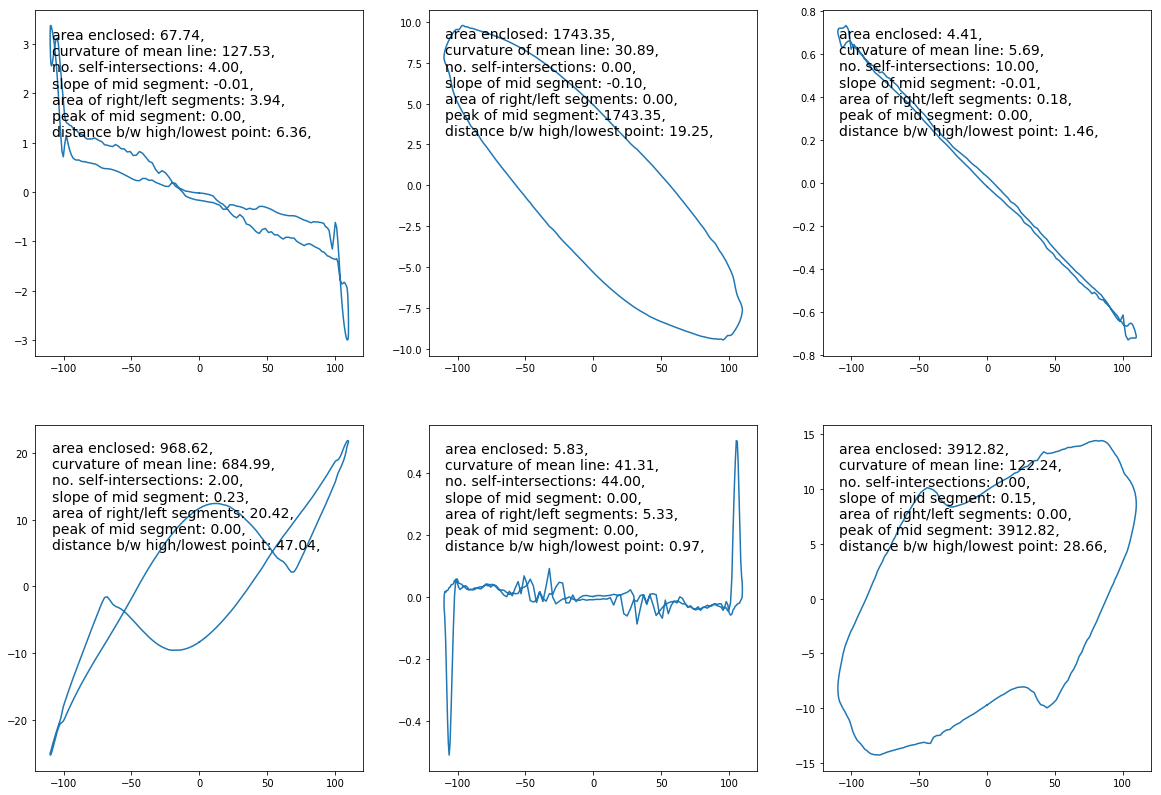

In [4]:
# Visualize VI-trajectory based feature space estimates for key REDD waveforms
labels = ['area enclosed', 'curvature of mean line', 'no. self-intersections', 
          'slope of mid segment', 'area of right/left segments', 
          'peak of mid segment', 'distance b/w high/lowest point']

fig, ax = plt.subplots(2,3,figsize=(20,14))
px = 0

for idx in range(numWaveforms):
    py = idx
    if idx>2:
        py = idx%3
        px = 1
    coll = np.array([labels[ii]+': '+'{0:.2f}'.format(np.round(wfFeatures[idx,ii],3))+', ' 
                     for ii in range(numFeatures)]).T
    
    ax[px,py].plot(vol,wf[idx,:],'-')
    ax[px,py].text(.9*ax[px,py].get_xlim()[0], .9*ax[px,py].get_ylim()[1], "\n".join(coll),
                   verticalalignment='top', fontsize=14)